# PyTorch vs Lightning
On [official PyTorch Lightning website](https://lightning.ai), there are mainly 2 introductory materials now(June 28, 2023, v2.0.4)  
- [colab notebook - hell pytorch lightning](https://colab.research.google.com/drive/1AZ5SM6zX13h4rOKxnIAYrg3N40fJFFQo?usp=sharing#scrollTo=HWB7-7yx-gxT)  
- [Document - Lightning in 15 minutes](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)  
As I'm not that familiar with both PyTorch and Lightning, I'm going to convert some model between them.  



# Exercise 1.


## 1. Just reproduce outputs.
First, let's convert an autoencoder model on materials above(Both materials uses same model as an example). It encodes images from MNIST dataset as a 3-dimensional latent vector.
Let's just reproduce results.

In [1]:
import os, torch, torch.nn as nn, torch.utils.data as data, torchvision as tv
import lightning as L

encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 3))
decoder = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

dataset = tv.datasets.MNIST(".", download=True, transform=tv.transforms.ToTensor())

trainer = L.Trainer(max_steps=5000)
trainer.fit(LitAutoEncoder(encoder, decoder), data.DataLoader(dataset, batch_size=32))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 100 K 
1 | decoder | Sequential | 101 K 
---------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.810     Total estimated model params size (MB)
c:\Users\hms_l\.conda\envs\rave2_py39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.


In [2]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

In [22]:
# load checkpoint
checkpoint = "./lightning_logs/version_1/checkpoints/epoch=53-step=50000.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = torch.Tensor(4, 28 * 28).cuda() # Original code without .cuda() raised an error - cuz there are two devices.
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[ 0.2866, -0.5402,  0.0124],
        [ 0.5535, -0.6263,  0.2129],
        [ 0.7273, -0.9737,  0.1227],
        [ 0.3660, -0.6094,  0.0933]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


There were some problems so I had to add cuda() method on
```python
fake_image_batch = torch.Tensor(4, 28 * 28).cuda()
```  

## 2. Visualization
This autoencoder can work as an image generator. Let's check out...

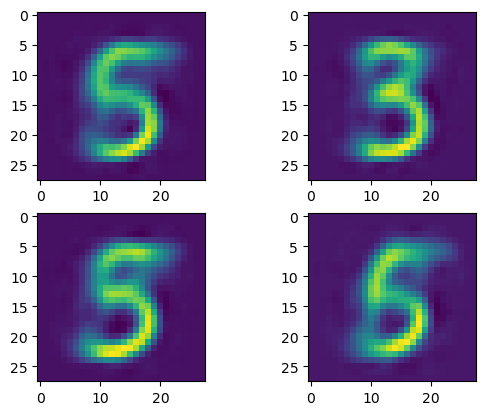

In [23]:
# regenerate fake images!
fake_image_batch = (torch.rand(4, 28*28)).cuda() # Original code without .cuda() raised an error - cuz there are two devices.
embeddings = encoder(fake_image_batch)

#import pyplot to plot
import matplotlib.pyplot as plt

# initialize decoder
decoder = autoencoder.decoder
decoder.eval()

#generate images, plot
gen_imgs = decoder(embeddings).cpu().detach().view(4,28,28).numpy()
plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(gen_imgs[i])

Let's plot comparison between input image and restored image. (an autoencoder model usually exhibits.)

type(X):<class 'torch.Tensor'>, type(y):<class 'torch.Tensor'>
size of X:torch.Size([4, 1, 28, 28]), y:torch.Size([4])
tensor([5, 9, 1, 4])


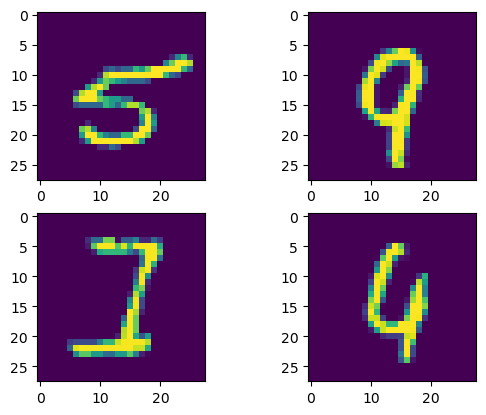

In [28]:


dataloader = data.DataLoader(dataset, batch_size=4, shuffle=True)
'''
for X, y in dataloader:
    print(f"type(X):{type(X)}, type(y):{type(y)}")
    print(f"size of X:{X.size()}, y:{y.size()}")
    print(y)
    X = X.view(4, 28, 28)
    break
'''
_, (X, y) = next(enumerate(dataloader)) # Dataloader seems iterable but next(Dataloader) does not work! ref: https://stackoverflow.com/questions/63487775
print(f"type(X):{type(X)}, type(y):{type(y)}")
print(f"size of X:{X.size()}, y:{y.size()}")
print(y)
X = X.view(4, 28, 28)


    #plot input images
plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(X[i])
    

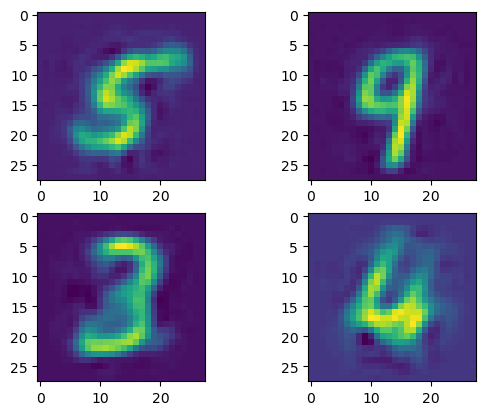

In [29]:
embeddings = encoder(X.view(4, 28*28).cuda())
gen_imgs = decoder(embeddings).cpu().detach().view(4,28,28).numpy()

#plot restored images
plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(gen_imgs[i])

### Discussion/Question
1. Batch Size : Batch size was 64 or 32 on dataloader on trainer.fit(). I tried 4, 8 on inference step. Is it okay to change batch size between training and inference stage on raw PyTorch or TensorFlow?
2. Subdirectory generated : So many directories & files generated...  'MNIST\raw' is the downloaded dataset from PyTorch dataset. 'lightning_logs' have three files. checkpoint(.ckpt), 'events.out.tfevents....', 'hparams.yaml'. What's the role of these files?
3. Use of tensorboard : I'm using jupyter notebook on VS Code. Unlike google colab, I can't see the tensorboard page on cell output. Instead, it toggles 'launch tensorboard session'. What's happening?

## 3. Convert to Raw PyTorch
I've reproduced [pytorch quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) on [this repository](../torch_quickstart/quickstart.ipynb). Let's Convert the model above to the model only use raw pytorch. It'll will be just some modification of the pytorch quickstart.  
Python code below should be independently runnable.

## 3.1. Import modules, Load dataset

In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.MNIST(root=".",train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root=".",train=False, download=True, transform=ToTensor())

In [30]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"size of X: {X.size()}")
    print(f"shape of X: {X.shape}")
    break

size of X: torch.Size([64, 1, 28, 28])
shape of X: torch.Size([64, 1, 28, 28])


On PyTorch Lightning, just a dataset was passed to the trainer. There were no parameter about train-test data split.   
Question or Discussion   
- Does lightning model use 'test data' on training? default value of train argument is True.  
- Difference of Tensor.size() and X.shape?

### 3.2.Define Model
Encoder and Decoder can be included in the autoencoder but let's declare separatly.

In [27]:
#device: I have only cpu and gpu. skip mps or tpu
device = ("cuda" if torch.cuda.is_available()
          else "cpu")
print(f"using {device}")

#model

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        embeddings = self.linear_relu_stack(x)
        return embeddings

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28)
        )
    
    def forward(self, embeddings):
        output = self.linear_relu_stack(embeddings)
        output = output.view(-1, 1, 28, 28) #It cannot be (batch_size, 1, 28, 28) cuz dataloader gives 
        return output

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        embeddings = self.encoder(x)
        output = self.decoder(embeddings)
        return output
    
model = AutoEncoder().to(device)
print(model)

using cuda
AutoEncoder(
  (encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)


### 3.3. Train

In [31]:
loss_fn = nn.MSELoss() #on lightning, just nn.functional.mse_loss() was used. It seems like nn.MSELoss() returns nn.functional.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() #what is the role of this method?
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, X) #this is autoencoder. y is not used.

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [33]:
help(model.train)

Help on method train in module torch.nn.modules.module:

train(mode: bool = True) -> ~T method of __main__.AutoEncoder instance
    Sets the module in training mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    Args:
        mode (bool): whether to set training mode (``True``) or evaluation
                     mode (``False``). Default: ``True``.
    
    Returns:
        Module: self



In [34]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [35]:
epochs = 53
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.126894 [   64/60000]
loss: 0.135520 [32064/60000]
Test Error: 
 Avg loss: 0.129333 

Epoch 2
-------------------------------
loss: 0.124184 [   64/60000]
loss: 0.132856 [32064/60000]
Test Error: 
 Avg loss: 0.126909 

Epoch 3
-------------------------------
loss: 0.121793 [   64/60000]
loss: 0.130467 [32064/60000]
Test Error: 
 Avg loss: 0.124715 

Epoch 4
-------------------------------
loss: 0.119624 [   64/60000]
loss: 0.128280 [32064/60000]
Test Error: 
 Avg loss: 0.122695 

Epoch 5
-------------------------------
loss: 0.117631 [   64/60000]
loss: 0.126255 [32064/60000]
Test Error: 
 Avg loss: 0.120812 

Epoch 6
-------------------------------
loss: 0.115779 [   64/60000]
loss: 0.124358 [32064/60000]
Test Error: 
 Avg loss: 0.119043 

Epoch 7
-------------------------------
loss: 0.114038 [   64/60000]
loss: 0.122566 [32064/60000]
Test Error: 
 Avg loss: 0.117368 

Epoch 8
-------------------------------
loss: 0.112391 [   64/60000]


### 3.4. Visualization
It's modified from previous visualization on this notebook.

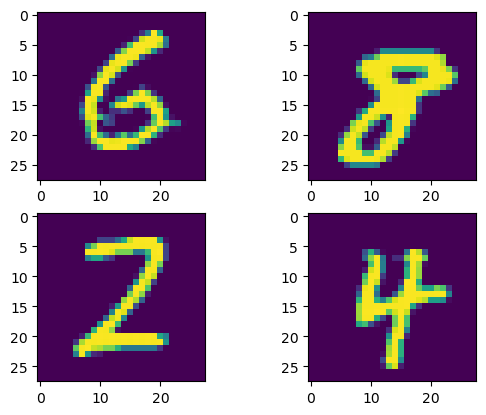

In [38]:
import matplotlib.pyplot as plt

dataloader = DataLoader(training_data, batch_size=4, shuffle=True)

_, (X, y) = next(enumerate(dataloader))
X = X.view(4, 28, 28)

#plot input images
plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(X[i])
    

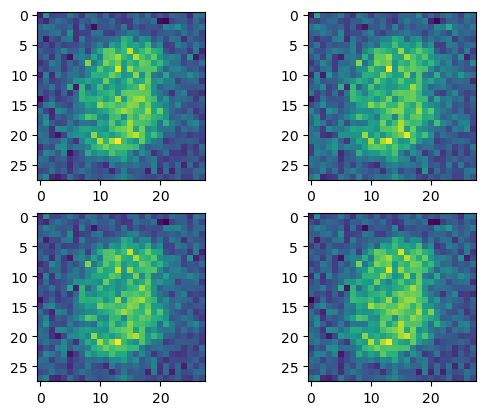

In [39]:
output = model(X.cuda())
gen_imgs = output.cpu().detach().view(4,28,28).numpy()

#plot restored images
plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(gen_imgs[i])

Something is wrong here.. After training 53 epochs, it cannot restore inputs at all.